In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats
import seaborn as sbs

This notebook analyzes two datasets, from Costanzo et al 2016 and Costanzo et al 2021, to generate Figure 4d in the manuscript.


Import data from Costanzo et al (Science 2021).

In [9]:
datadir = "data/"
filename ="Costanzo et al_Data File S1_Conditions_Strains_Fitness.xlsx"

In [10]:
df_env = pd.read_excel(datadir+filename,sheet_name=5).drop(['Systematic Name',
                                                            'Allele (Essential genes only)',
                                                            'Strain ID', 
                                                            'on Diagnostic Array'],
                                                            axis = 1)
df_env['Gene Name'] = df_env['Gene Name'].astype(str)
df_env = df_env[df_env['Gene Name']!='nan']

df_env.head()

,Gene Name,Actinomycin D,Benomyl,Boretzeomib,Caspofungin,Concanmycin A,Cycloheximide,Fluconozole,Galactose,Geldenamycin,MMS,Monensin,Rapamycin,Sorbitol,Tunicamycin
0,TFC3,0.0050,0.1380,-0.0220,-0.0180,0.0280,-0.0080,0.0510,0.0400,-0.0250,0.0290,-0.0370,-0.0020,-0.0370,-0.0240
1,VPS8,-0.4890,-0.1980,-0.1150,-0.0360,-0.1320,-0.0450,-0.0270,-0.0940,-0.0670,-0.0520,-0.0330,-0.2965,-0.1115,-0.0850
3,SSA1,-0.0310,0.0100,-0.0150,0.0260,-0.0460,-0.0020,0.0750,-0.0250,-0.0040,-0.0130,-0.0230,0.2015,0.1265,0.0430
4,ERP2,-0.0315,0.0295,0.0215,-0.0505,0.0585,0.0205,0.0215,0.0145,0.0335,-0.0435,-0.0085,0.0835,-0.0265,-0.0105
5,FUN14,0.0195,-0.0135,-0.0275,0.0315,0.0315,0.0335,-0.0515,0.0255,0.0555,0.0005,0.0225,0.0410,-0.0280,-0.0225


In [11]:
env_mat = np.array(df_env.drop('Gene Name',axis=1))
mask = np.sum(np.isnan(env_mat),axis=1)==0
env_mat = env_mat[mask,:]
env_mat = env_mat - np.mean(env_mat,axis = 0)
env_mat.shape
d = {'Gene Name':df_env['Gene Name'][mask],"Mean Env Effect": np.mean(env_mat,axis = 1)}
df_env_rob = pd.DataFrame(data = d)
df_env_rob.head()

,Gene Name,Mean Env Effect
0,TFC3,0.023532
1,VPS8,-0.112111
3,SSA1,0.038175
4,ERP2,0.023104
5,FUN14,0.023532


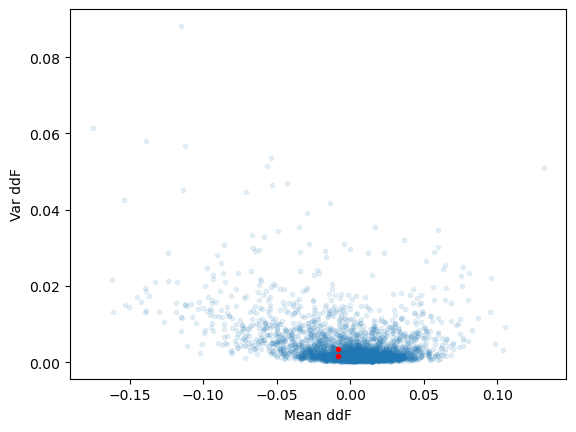

In [12]:
mean_ddF = np.mean(env_mat,axis = 1)
var_ddF = np.var(env_mat,axis = 1)
plt.scatter(mean_ddF,var_ddF,marker = '.', alpha = 0.1)
plt.scatter(mean_ddF[df_env_rob['Gene Name'] == 'HSC82'],var_ddF[df_env_rob['Gene Name'] == 'HSC82'],marker = '.', alpha = 1,color = 'red')
plt.scatter(mean_ddF[df_env_rob['Gene Name'] == 'HSC82'],var_ddF[df_env_rob['Gene Name'] == 'HSP82'],marker = '.', alpha = 1,color = 'red')

plt.ylabel('Var ddF')
plt.xlabel('Mean ddF')
plt.show()

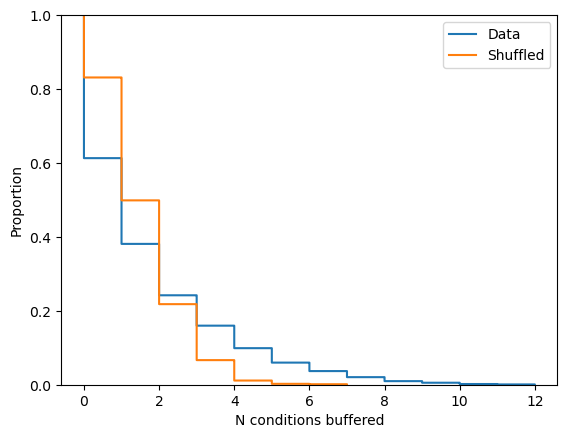

In [13]:
env_mat = np.array(df_env.drop('Gene Name',axis=1))
binarized = env_mat <-.08
sbs.ecdfplot(x=np.sum(binarized,axis =1 ),complementary=True,label="Data" )
idx = np.random.rand(*binarized.shape).argsort(0)
to_shuffle = binarized[idx, np.arange(binarized.shape[1])]
sbs.ecdfplot(x=np.sum(to_shuffle,axis = 1),complementary=True, label = 'Shuffled' )
plt.ylim((0,1))
plt.xlabel("N conditions buffered")
plt.legend()
plt.show()

In [14]:
df_binarized_env = pd.DataFrame(data = {'Gene Name' : df_env['Gene Name'],'Neg Env':np.sum(binarized,axis =1 ) })
df_binarized_env.head()

,Gene Name,Neg Env
0,TFC3,0
1,VPS8,8
3,SSA1,0
4,ERP2,0
5,FUN14,0


Import data from Costanzo et al (Science 2016).

In [15]:
filename = 'SGA_NxN.txt'
df_mut = pd.read_csv(datadir+filename,sep='\t').drop(['Query Strain ID',
                                                      'Array Strain ID',
                                                      'Arraytype/Temp', 
                                                      'Array SMF',
                                                      'Query single mutant fitness (SMF)',
                                                      'Double mutant fitness', 
                                                      'Double mutant fitness standard deviation'],
                                                    axis = 1)
for col in np.array(['Array allele name','Query allele name']):
    df_mut[col] = df_mut[col].astype(str)
    df_mut = df_mut[df_mut[col]!='nan']
#df_mut = df_mut.rename(columns={"Query single mutant fitness (SMF)": "Query SMF"})

df_mut.head()

,Query allele name,Array allele name,Genetic interaction score (ε),P-value
0,vps8,ecm15,0.1157,0.000755
1,vps8,hta2,0.0290,0.250000
2,vps8,pdr3,-0.0278,0.241800
3,vps8,sla1,-0.0554,0.164900
4,vps8,hir1,0.0638,0.004134


In [16]:
df_mut_int = df_mut.pivot_table(index = "Query allele name", columns = "Array allele name", values = "Genetic interaction score (ε)",aggfunc='mean')
df_mut_p = df_mut.pivot_table(index = "Query allele name", columns = "Array allele name", values = "P-value",aggfunc='mean')
df_mut_int.head()

Array allele name,aac1,aac3,aad3,aad4,aad6,aah1,aap1,aat1,abm1,abp1,...,zds2,zeo1,zip1,zip2,znf1,zrc1,zrg17,zrt2,zrt3,zta1
Query allele name,,,,,,,,,,,,,,,,,,,,,
aac1,NaN,-0.0147,0.0241,-0.0254,-0.0068,-0.0565,0.0172,-0.0209,0.0057,0.0170,...,NaN,-0.0290,0.0096,0.0124,-0.0088,NaN,-0.0021,-0.0284,0.0633,-0.0056
aac3,-0.0203,NaN,0.0417,-0.0474,-0.1490,0.0233,0.0402,0.0675,0.0454,NaN,...,0.0287,0.0191,0.0224,0.0696,0.0621,-0.0879,0.0713,0.0268,-0.0757,NaN
aad10,-0.0128,-0.0079,0.0094,-0.0006,-0.0430,-0.0087,0.0027,-0.0481,NaN,0.0586,...,-0.0298,-0.0378,0.0606,0.0347,0.0100,-0.0349,-0.0210,-0.0061,NaN,0.0307
aad14,0.0121,-0.0209,0.0054,-0.0067,-0.0404,-0.0557,-0.0050,-0.0458,-0.0082,-0.0088,...,0.0645,0.0295,-0.0326,0.0177,0.0412,-0.0412,0.0160,-0.0011,-0.0062,0.0021
aad15,-0.0307,0.0051,0.0584,-0.0232,0.0425,-0.0802,-0.0272,0.0181,-0.0359,0.0401,...,0.0087,NaN,0.0214,-0.0121,-0.0065,0.0368,-0.0801,-0.0045,-0.0413,-0.0769


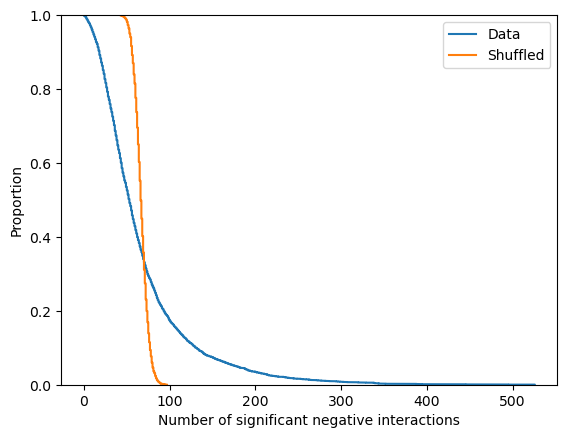

In [17]:
binarized_int = (np.array(df_mut_int) < -0.08) & (np.array(df_mut_p) < 0.05)
sbs.ecdfplot(x=np.sum(binarized_int,axis = 1),complementary=True ,label = 'Data')
idx = np.random.rand(*binarized_int.shape).argsort(0)
to_shuffle = binarized_int[idx, np.arange(binarized_int.shape[1])]
sbs.ecdfplot(x=np.sum(to_shuffle,axis = 1),complementary=True, label = 'Shuffled' )
plt.xlabel('Number of significant negative interactions')
plt.legend()
plt.show()

In [18]:
df_binarized_mut = pd.DataFrame(data = {'Gene Name' : df_mut_int.index,'Neg Mut':np.sum(binarized_int,axis = 1) })
df_binarized_mut.head()

,Gene Name,Neg Mut
0,aac1,11
1,aac3,133
2,aad10,35
3,aad14,58
4,aad15,36


In [19]:
df_binarized_mut['Gene Name'] = df_binarized_mut['Gene Name'].apply(str.upper)
df_binarized_env['Gene Name'] = df_binarized_env['Gene Name'].apply(str.upper)
df_binarized = pd.merge(df_binarized_mut,df_binarized_env,how = "inner",on="Gene Name")
df_binarized.head()

,Gene Name,Neg Mut,Neg Env
0,AAC1,11,0
1,AAC3,133,1
2,AAD4,73,0
3,AAP1,11,1
4,AAT1,64,0


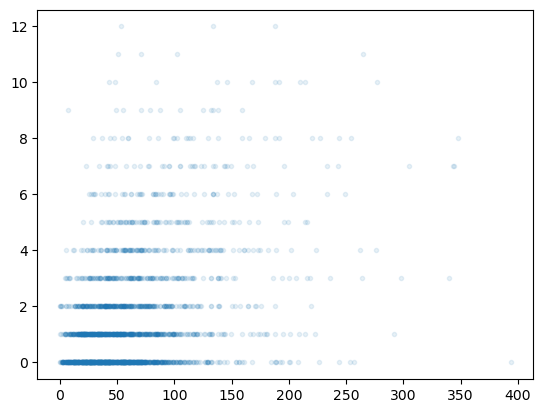

In [20]:
plt.scatter(df_binarized['Neg Mut'],df_binarized['Neg Env'],marker = ".",alpha = 0.1)


In [21]:
np.unique(df_binarized['Neg Env'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

This generates figure 4d in the manuscript; previous figures in this notebook are exploratory

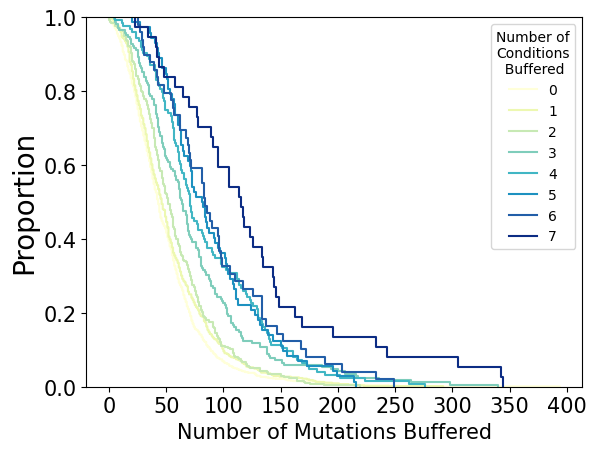

In [23]:
import palettable.colorbrewer.sequential as pal
from matplotlib.colors import ListedColormap
plt.rcParams['svg.fonttype'] = 'none'

colors = pal.YlGnBu_8.mpl_colors
for i in range(0,8):
    sbs.ecdfplot(x=df_binarized['Neg Mut'][df_binarized['Neg Env'] == i],complementary=True ,label = i,color = colors[i])
legend = plt.legend()
legend.set_title('Number of\nConditions\n  Buffered')
plt.xlabel('Number of Mutations Buffered', fontsize=15)
plt.ylabel('Proportion', fontsize=20)
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.savefig('fig4d.svg')
# Increase the tick size for both x and y axes
for tick in xticks + yticks:
    tick.set_fontsize(15)
#plt.yscale('log')
#plt.xscale('log')

In [24]:
df_binarized.sort_values('Neg Mut',ascending = False)[0:20]

,Gene Name,Neg Mut,Neg Env
523,ECM4,394,0
1593,RIC1,348,8
369,CSG2,344,7
908,IRA2,343,7
245,BTS1,340,3
704,GET2,305,7
445,DEP1,298,3
1119,MNN11,292,1
1434,PMR1,277,10
888,IMP2,276,4


In [25]:
df_binarized.sort_values('Neg Env',ascending = False)[0:20]

,Gene Name,Neg Mut,Neg Env
2178,UME6,134,12
1535,RAD4,53,12
1214,NBP2,188,12
2230,VPS41,71,11
2202,VAM7,51,11
2229,VPS4,102,11
2224,VPS27,265,11
896,INO2,84,10
1491,PTC1,214,10
2232,VPS51,168,10


In [32]:
scipy.stats.spearmanr(df_binarized['Neg Mut'],df_binarized['Neg Env'])

SignificanceResult(statistic=0.31234227445833457, pvalue=4.0408443759135443e-54)